<a href="https://colab.research.google.com/github/jianzhiw/NLP/blob/master/Keyword_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import kaggle.json from google drive
# This snippet will output a link which needs authentication from any google account
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
    q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
# print(kaggle_api_key)
filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


Run two times

In [3]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v /content

- path is now set to: /content


# Dataset #

[Neural Information Processing Systems (NIPS)](https://www.kaggle.com/benhamner/nips-papers/home) is one of the top machine learning conferences in the world. This dataset includes the title and abstracts for all NIPS papers to date. 

In [4]:
!kaggle datasets download -d benhamner/nips-papers

 93% 131M/141M [00:02<00:00, 46.2MB/s]
100% 141M/141M [00:02<00:00, 53.8MB/s]


In [0]:
!mv /content/datasets/benhamner/nips-papers/nips-papers.zip nips-papers.zip

In [6]:
!unzip nips-papers.zip

Archive:  nips-papers.zip
  inflating: database.sqlite         
  inflating: papers.csv              
  inflating: paper_authors.csv       
  inflating: authors.csv             


In [17]:
import pandas
# load the dataset
dataset = pandas.read_csv('papers.csv')
dataset.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


Remove rows without any abstract.

In [21]:
cleaned = dataset.drop(dataset.index[dataset['abstract'] == 'Abstract Missing']).reset_index()
cleaned = cleaned.drop(columns=['index', 'title', 'event_type', 'pdf_name', 'paper_text'])
cleaned.head()

,id,year,abstract
0,1861,2000,Non-negative matrix factorization (NMF) has pr...
1,1975,2001,Spike-triggered averaging techniques are effec...
2,3163,2007,It is known that determinining whether a DEC-P...
3,3164,2007,We present the first truly polynomial algorith...
4,3167,2007,Semi-supervised inductive learning concerns ho...


# Preliminary text exploration #
Before we proceed with any text pre-processing, it is advisable to quickly explore the dataset in terms of word counts, most common and most uncommon words.

In [22]:
#Fetch wordcount for each abstract
cleaned['word_count'] = cleaned['abstract'].apply(lambda x: len(str(x).split(" ")))
cleaned[['abstract','word_count']].head()

,abstract,word_count
0,Non-negative matrix factorization (NMF) has pr...,107
1,Spike-triggered averaging techniques are effec...,81
2,It is known that determinining whether a DEC-P...,67
3,We present the first truly polynomial algorith...,143
4,Semi-supervised inductive learning concerns ho...,119


In [25]:
#Descriptive statistics of word counts
cleaned['word_count'].describe()

count    3924.000000
mean      148.390928
std        45.605755
min        19.000000
25%       116.000000
50%       143.000000
75%       177.000000
max       317.000000
Name: word_count, dtype: float64

# Most common and uncommon words #
A peek into the most common words gives insights not only on the frequently used words but also words that could also be potential data specific stop words. A comparison of the most common words and the default English stop words will give us a list of words that need to be added to a custom stop word list.

In [26]:
#Identify common words
freq = pandas.Series(' '.join(dataset['abstract']).split()).value_counts()[:20]
freq

the         29793
of          20918
a           16339
and         13626
to          12869
in           8980
that         7838
is           7666
for          7169
We           6238
on           5579
we           5167
with         4512
this         3677
as           3643
are          3529
an           3366
Abstract     3323
Missing      3318
by           3197
dtype: int64

In [27]:
#Identify uncommon words
freq1 =  pandas.Series(' '.join(dataset 
         ['abstract']).split()).value_counts()[-20:]
freq1

\emph{Inverse            1
feedbacks,               1
gotten                   1
\mathcal{A}({\bf         1
Monitoring               1
multi-sense              1
consequently.            1
lists).                  1
10x                      1
Fair                     1
registered,              1
VAMP)                    1
diffusion-weighted       1
brain-actuated           1
sequences:               1
neurometric              1
chimeras,                1
erarchical               1
Continuously-Adaptive    1
anlysis                  1
dtype: int64

# Text Pre-processing #

Text pre-processing can be divided into two broad categories — noise removal & normalization. Data components that are redundant to the core text analytics can be considered as noise.
<br></br>
Handling multiple occurrences / representations of the same word is called normalization. There are two types of normalization — stemming and lemmatization. 

In [28]:
# Libraries for text preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer 
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
# Creating a list of stop words and adding custom stopwords
stop_words = set(stopwords.words("english"))
# Creating a list of custom stopwords
new_words = ["using", "show", "result", "large", "also", "iv", "one", "two", "new", "previously", "shown"]
stop_words = stop_words.union(new_words)

In [0]:
corpus = []
for i in cleaned['abstract']:
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', i)
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    ##Stemming
    ps=PorterStemmer()
    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)

In [33]:
corpus[:10]

['non negative matrix factorization nmf useful decomposition multivariate data different multi plicative algorithm nmf analyzed differ slightly multiplicative factor used update rule algorithm minimize conventional least square error minimizes generalized kullback leibler divergence monotonic convergence algorithm proven auxiliary func tion analogous used proving convergence expectation maximization algorithm algorithm interpreted diag onally rescaled gradient descent rescaling factor optimally chosen ensure convergence',
 'spike triggered averaging technique effective linear characterization neural response neuron exhibit important nonlinear behavior gain control captured analysis describe spike triggered covariance method retrieving suppressive component gain control signal neuron demonstrate method simulation retinal ganglion cell data analysis physiological data reveals significant suppressive ax explains neural nonlinearities method applicable sensory area modality',
 'known deter

# Data Exploration #
We will now visualize the text corpus that we created after pre-processing to get insights on the most frequently used words.

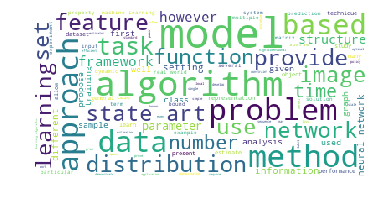

In [34]:
#Word cloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
% matplotlib inline
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(corpus))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

# Text preparation #
Text in the corpus needs to be converted to a format that can be interpreted by the machine learning algorithms. There are 2 parts of this conversion — Tokenisation and Vectorisation.
<br></br>
For text preparation we use the bag of words model which ignores the sequence of the words and only considers word frequencies.

# Creating a vector of word counts #
As the first step of conversion, we will use the CountVectoriser to tokenise the text and build a vocabulary of known words. We first create a variable “cv” of the CountVectoriser class, and then evoke the fit_transform function to learn and build the vocabulary.

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
import re
cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(corpus)

In [36]:
list(cv.vocabulary_.keys())[:10]

['non',
 'negative',
 'matrix',
 'factorization',
 'nmf',
 'useful',
 'decomposition',
 'multivariate',
 'data',
 'different']

# Visualize top N uni-grams, bi-grams & tri-grams #
We can use the CountVectoriser to visualise the top 20 unigrams, bi-grams and tri-grams.

[Text(0, 0, 'model'),
 Text(0, 0, 'algorithm'),
 Text(0, 0, 'learning'),
 Text(0, 0, 'method'),
 Text(0, 0, 'problem'),
 Text(0, 0, 'data'),
 Text(0, 0, 'approach'),
 Text(0, 0, 'function'),
 Text(0, 0, 'based'),
 Text(0, 0, 'network'),
 Text(0, 0, 'time'),
 Text(0, 0, 'paper'),
 Text(0, 0, 'result'),
 Text(0, 0, 'task'),
 Text(0, 0, 'distribution'),
 Text(0, 0, 'propose'),
 Text(0, 0, 'state'),
 Text(0, 0, 'feature'),
 Text(0, 0, 'image'),
 Text(0, 0, 'performance')]

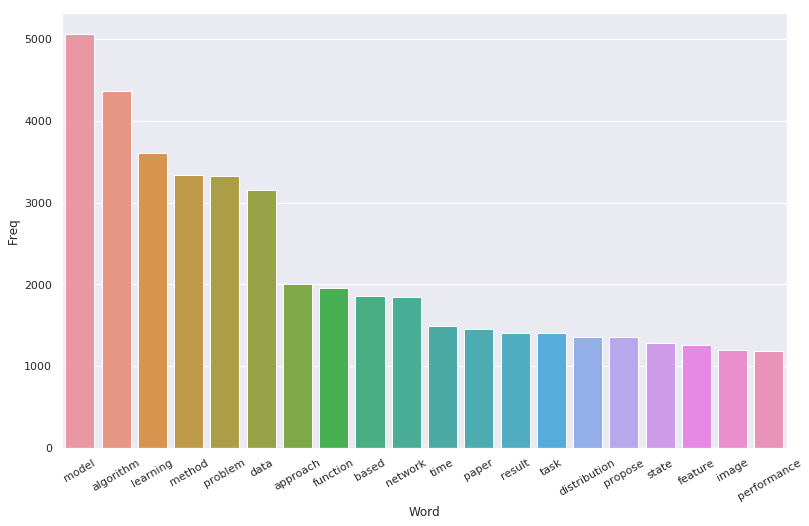

In [37]:
#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, n=20)
top_df = pandas.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
#Barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

                   Bi-gram  Freq
0                state art   718
1           neural network   561
2         machine learning   413
3               real world   376
4       learning algorithm   350
5         high dimensional   326
6              lower bound   259
7                 data set   239
8            paper propose   237
9     optimization problem   225
10         graphical model   224
11     experimental result   220
12           loss function   208
13  reinforcement learning   205
14                low rank   202
15        gradient descent   188
16        gaussian process   184
17        learning problem   180
18        convergence rate   178
19     stochastic gradient   175


[Text(0, 0, 'state art'),
 Text(0, 0, 'neural network'),
 Text(0, 0, 'machine learning'),
 Text(0, 0, 'real world'),
 Text(0, 0, 'learning algorithm'),
 Text(0, 0, 'high dimensional'),
 Text(0, 0, 'lower bound'),
 Text(0, 0, 'data set'),
 Text(0, 0, 'paper propose'),
 Text(0, 0, 'optimization problem'),
 Text(0, 0, 'graphical model'),
 Text(0, 0, 'experimental result'),
 Text(0, 0, 'loss function'),
 Text(0, 0, 'reinforcement learning'),
 Text(0, 0, 'low rank'),
 Text(0, 0, 'gradient descent'),
 Text(0, 0, 'gaussian process'),
 Text(0, 0, 'learning problem'),
 Text(0, 0, 'convergence rate'),
 Text(0, 0, 'stochastic gradient')]

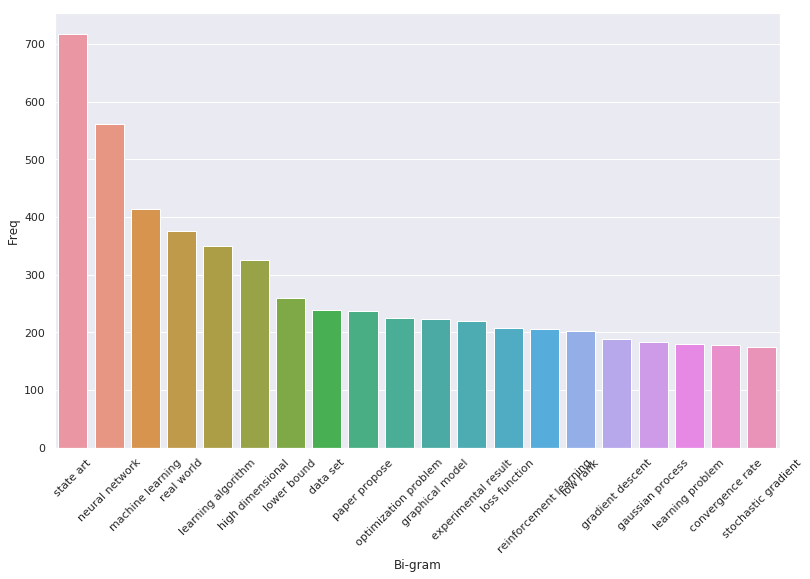

In [38]:
#Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top2_words = get_top_n2_words(corpus, n=20)
top2_df = pandas.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)
#Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45)

                        Tri-gram  Freq
0   convolutional neural network   100
1            deep neural network    96
2    stochastic gradient descent    84
3          state art performance    82
4            real world datasets    76
5       recurrent neural network    73
6               state art method    73
7                real world data    68
8        markov decision process    63
9                low rank matrix    63
10          synthetic real world    62
11      semi supervised learning    61
12            multi armed bandit    61
13         outperforms state art    60
14              state art result    60
15         latent variable model    57
16            markov chain monte    55
17             chain monte carlo    55
18  principal component analysis    50
19   empirical risk minimization    50


[Text(0, 0, 'convolutional neural network'),
 Text(0, 0, 'deep neural network'),
 Text(0, 0, 'stochastic gradient descent'),
 Text(0, 0, 'state art performance'),
 Text(0, 0, 'real world datasets'),
 Text(0, 0, 'recurrent neural network'),
 Text(0, 0, 'state art method'),
 Text(0, 0, 'real world data'),
 Text(0, 0, 'markov decision process'),
 Text(0, 0, 'low rank matrix'),
 Text(0, 0, 'synthetic real world'),
 Text(0, 0, 'semi supervised learning'),
 Text(0, 0, 'multi armed bandit'),
 Text(0, 0, 'outperforms state art'),
 Text(0, 0, 'state art result'),
 Text(0, 0, 'latent variable model'),
 Text(0, 0, 'markov chain monte'),
 Text(0, 0, 'chain monte carlo'),
 Text(0, 0, 'principal component analysis'),
 Text(0, 0, 'empirical risk minimization')]

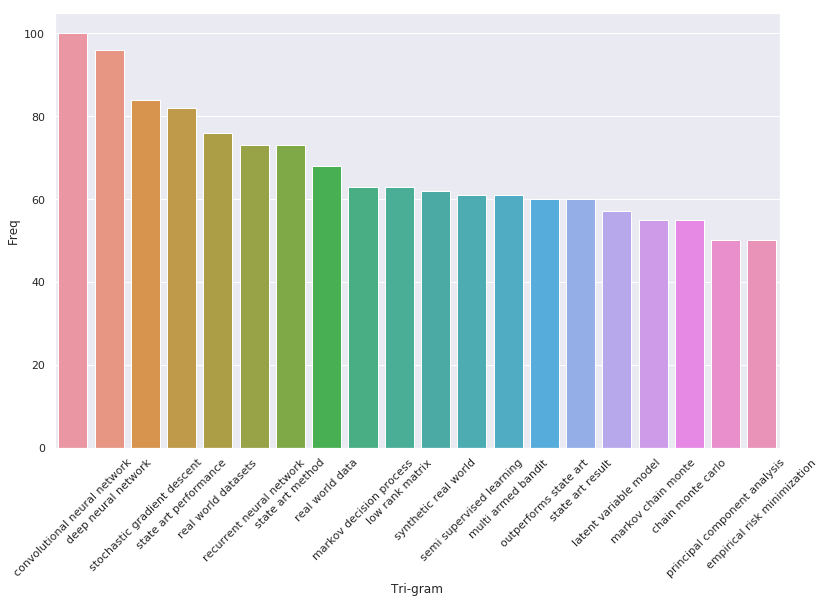

In [39]:
#Most frequently occuring Tri-grams
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top3_words = get_top_n3_words(corpus, n=20)
top3_df = pandas.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
print(top3_df)
#Barplot of most freq Tri-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=45)

# Converting to a matrix of integers #
The next step of refining the word counts is using the TF-IDF vectoriser. The deficiency of a mere word count obtained from the countVectoriser is that, large counts of certain common words may dilute the impact of more context specific words in the corpus. This is overcome by the TF-IDF vectoriser which penalizes words that appear several times across the document. TF-IDF are word frequency scores that highlight words that are more important to the context rather than those that appear frequently across documents.

In [0]:
from sklearn.feature_extraction.text import TfidfTransformer
 
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)
# get feature names
feature_names=cv.get_feature_names()

In [0]:
#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix

def sort_coo(coo_matrix):
  tuples = zip(coo_matrix.col, coo_matrix.data)
  return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
  #use only topn items from vector
  sorted_items = sorted_items[:topn]
  score_vals = []
  feature_vals = []
    
  # word index and corresponding tf-idf score
  for idx, score in sorted_items:
        
    #keep track of feature name and its corresponding score
    score_vals.append(round(score, 3))
    feature_vals.append(feature_names[idx])
  
  #create a tuples of feature,score
  #results = zip(feature_vals,score_vals)
  results= {}
  for idx in range(len(feature_vals)):
    results[feature_vals[idx]]=score_vals[idx]
    
  return results


In [54]:
# fetch document for which keywords needs to be extracted
doc=corpus[30]
#generate tf-idf for the given document
tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())
#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items,5)
 
# now print the results
print("\nAbstract:")
print(doc)
print("\nKeywords:")
for k in keywords:
    print(k,keywords[k])


Abstract:
peristimulus time historgram psth continuous cousin spike density function sdf staple analytic toolkit neurophysiologists former usually obtained binning spiketrains whereas standard method latter smoothing gaussian kernel selection bin kernel size often done relatively arbitrary fashion even though recent attempt remedy situation cite shimazakibinningnips shimazakibinningneco develop exact bayesian generative model approach estimating pshts demonstate superiority competing method advantage scheme include automatic complexity control error bar prediction

Keywords:
bar 0.206
kernel selection 0.202
kernel 0.195
standard method 0.192
remedy 0.192


[Source](https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34)

Prepared by: [Wong Jian Zhi](https://github.com/jianzhiw)